<h1><center>UCZENIE MASZYNOWE W ANIMACJACH</center></h1>

<br></br>

<center><img src="pictures/logo.png"/></center>
<br></br>

<h2><center>Prowadzący: mgr inż. Szymon Datko</center></h2>

<h3>Grupa Alfa</h3>
<ul>
<li>Adam Polerowicz 243442</li>
<li>Marcin Wawszczak 235274</li>
<li>Bartosz Olszewski 243928</li>
</ul>

<br></br>

<h2>Temat: Wykorzystanie sieci GAN do zadania upscalingu</h2>

<br></br>

<h4>Zadanie polegało na wykorzystaniu sieci GAN do zwiększania rozdzielczości obrazów.</h4>

#  Implementacje open-source

<br></br>

Sieci GAN są stosunkowo nową architekturą. Szybko jednak znalazły zastosowanie przy zadaniach upscalingu i augmentacji. Na początku należało przeprowadzić analize dostępnych rozwiązań. Powszechnie znanym repozytorium wszelkich open-sourcowych projektów jest Github. Pośród wielu implementacji sieci GAN do zwiększania rozdzielczości obrazów [1][2], na szczególną uwagę zasługuje repozytorium IBM [3]. Zawiera ono miedzy innymi kod do szybkiej implementacji upscalera. Jest on w stanie zwiększyć rozdzielczość obrazu czterokrotnie. Użyty model został wytrenowany na 600 000 obrazach z OpenImagesV4 [4]. Jakość uzyskiwanych wyników została sprawdzona na trzech zbiorach danych (Set4, Set14 oraz BSD100). Użyto metryk PSNR (ang. peak signal to noise ratio) oraz SSIM (structural similarity index). Repozytorium zawiera API, które ułatwia pracę z modelem. Jego uruchomienie sprowadza się do ściągnięcia obrazu z rejestru Quay.io [5] poprzez Dockera [6]. 

Przeprowadzono kilkanaście inferencji z modelem używając obrazów znalezionych w grafice Google. Jakość uzyskanych obrazów oceniona organoleptycznie została określona jako nieidealna i w zależności od użytego obrazu pojawiały się artefakty.

<br></br>
<h4> Przykłady obrazów mocno odbiegających od oryginału </h4>
<br></br>

![10](.\pictures\Enchanced\10en.png)
![3](.\pictures\Enchanced\3en.png)

<br></br>
<h4> Przykłady obrazów prawie idealnych (drobne artefakty) </h4>
<br></br>

![6](.\pictures\Enchanced\6en.png)
![4](.\pictures\Enchanced\4en.png)

<br></br>
<h4> Przykłady obrazów nie do odróżnienia z oryginalnymi </h4>
<br></br>

![5](.\pictures\Enchanced\5en.png)
![7](.\pictures\Enchanced\7en.png)


# Metryki
<br></br>
W celu przeprowadzenia porównania obrazów referencyjnych i po uscalingu na podstawie innej niż organoleptyczna stworzono skrypty do liczenia SSIM oraz MSE (ang. mean square error). Nie można jednak całkowicie wykluczyć bliżej nieokreślonej metryki jaką jest ocena organoleptyczna. Autorzy pracy naukowej [7], na podstawie której został stworzony model IBM sugerują, że MOS (z ang. Mean Opinion Score) jest najlepszą metryką do oceny modelu tego typu. MOS jest średnią opinią tworzoną przez subiektywną opinię ludzi.

In [1]:
from IPython.display import display, HTML
from pathlib import Path
from PIL import Image
import pandas as pd

def resize_images(path : str, extension='png'):
    resize_factor = 4
    base_path = Path(path)
    data = []
    for image_path in base_path.glob('*.' + extension):
        subdata = []
        img = Image.open(image_path)
        size = img.size
        new_size = (int(size[0] / resize_factor), int(size[1] / resize_factor))
        subdata = [str(size), str(new_size), str(image_path.name)]
        data.append(subdata)
    df = pd.DataFrame(data)
    df.columns = ['Original size', 'New size', 'File name']
    display(HTML(df.to_html()))

In [2]:
resize_images('./pictures/Originals')

,Original size,New size,File name
0,"(1920, 1080)","(480, 270)",1.png
1,"(1920, 1080)","(480, 270)",10.png
2,"(1920, 1080)","(480, 270)",2.png
3,"(1920, 1080)","(480, 270)",3.png
4,"(1920, 1080)","(480, 270)",4.png
5,"(1920, 1080)","(480, 270)",5.png
6,"(1920, 1080)","(480, 270)",6.png
7,"(1920, 1080)","(480, 270)",7.png
8,"(1920, 1080)","(480, 270)",8.png
9,"(1920, 1080)","(480, 270)",9.png


In [3]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
import cv2

def mse(imageA, imageB):
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	return err

def print_compare(pathA : str, pathB : str, suffix='', extensions=['png', 'png']):
    base_path = Path(pathA).parent
    names, mses, sims = [], [], [] 
    
    for org_path in Path(pathA).glob('*.' + extensions[0]):
        orig = cv2.imread(str(Path(pathA).joinpath(str(org_path.stem) + '.' + extensions[0])))
        ench = cv2.imread(str(Path(pathB).joinpath(str(org_path.stem) + suffix + '.' +  extensions[1])))
        orig = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
        ench = cv2.cvtColor(ench, cv2.COLOR_BGR2GRAY)	
        mses.append(float("{:.2f}".format(mse(orig, ench))))
        sims.append(float("{:.4f}".format(ssim(orig, ench))))
        names.append(org_path.stem)

    merge = [names, mses, sims, [element * 100 for element in sims]]
    df = pd.DataFrame(merge)
    col = ['Image name', 'MSE', 'SSIM', 'SSIM %']
    df.insert(0, "Id", col, True)
    display(HTML(df.to_html()))
    means = [str(np.mean(mses))[:6], str(np.mean(merge[3]))[:5]]
    df = pd.DataFrame(means)
    col = ['MSE', 'SSIM %']
    df.insert(0, None, col, True)
    df.columns = ['Mean', 'Value']
    display(HTML(df.to_html()))

In [4]:
print_compare('./pictures/Originals/', './pictures/Enchanced/', 'en')

,Id,0,1,2,3,4,5,6,7,8,9,10
0,Image name,1,10,2,3,4,5,6,7,8,9,9_white
1,MSE,835.81,393.05,24262.87,170.67,19.74,80.59,32.44,6.84,3119.12,11698.99,206.67
2,SSIM,0.4739,0.8666,0.5329,0.7372,0.9307,0.903,0.9445,0.9838,0.8559,0.2107,0.7717
3,SSIM %,47.39,86.66,53.29,73.72,93.07,90.3,94.45,98.38,85.59,21.07,77.17


,Mean,Value
0,MSE,3711.5
1,SSIM %,74.64


# Samodzielne implementacje

<br></br>

Po wykonaniu przeglądu dostępnych rozwiązań podjęto się zadania wytrenowania sieci GAN samodzielnie. Wykorzystano w tym celu PyTorch-ową [8] implementacje architektury SRGAN [9]. Sieci GAN ze względu na swoją strukturę można opisać jako dwie współpracujące sieci. Oznacza to, że wytrenowanie sieci na podobnej ilości obrazów jak referencyjna sieć (600 000) wymagałoby dużo zasobów zarówno sprzętowych jak i czasowych. Postanowiono przeprowadzić porównanie sieci IBM z siecią  wytrenowaną na dużo mniejszym zbiorze ograniczonym do konkretnej tematyki. Wykorzystano zbiór danych URBAN100, który zawiera 100 zdjęć architektury i budowli z całego świata. Aby móc wytrenować sieć na tych danych należało skorzystać ze skryptu dzielącego zbiór na zbiór treningowy i walidacyjny. Strategia tworzenia danych potrzebnych do wytrenowania sieci sprowadza się na podziale pojedynczego zdjęcia na kilkanaście równych sobie co do wymiarów obrazów. W ten sposób ze stu obrazów postał zbiór treningowy, który liczy 29 020 instancji oraz walidacyjny z 1 451 instancjami. Sieć została wytrenowana na sprzęcie o następujących parametrach:
<ul>
    <li> CPU i7 6500u </li>
    <li> GPU GTX 940mx </li>
</ul>
Trening trwał około 36 godzin i został zatrzymany przy 33 epoce (early stopping).

Po uzyskaniu najlepszego modelu przystąpiono do porównania z siecią IBM. Użyto dziesięciu obrazów, które przedstawiały budowle.

In [5]:
resize_images('./pictures/Original', 'jpg')

,Original size,New size,File name
0,"(480, 360)","(120, 90)",1.jpg
1,"(384, 384)","(96, 96)",2.jpg
2,"(264, 400)","(66, 100)",3.jpg
3,"(336, 224)","(84, 56)",4.jpg
4,"(1024, 892)","(256, 223)",5.jpg
5,"(400, 348)","(100, 87)",6.jpg
6,"(300, 300)","(75, 75)",7.jpg
7,"(300, 300)","(75, 75)",8.jpg
8,"(316, 224)","(79, 56)",9.jpg


W ten sposób przygotowane obrazy podano sieci IBM i SRGAN jako dane wejściowe. W efekcie otrzymano czterokrotnie większe obrazy. Sieć SRGAN domyślnie zapisuje kanały obrazów w kolejności BGR a nie RGB. W celu ujednolicenia kolejności kolorów przerobiono je na RGB.

In [6]:
import math

def bgr2rgb(path : str, extension='png'):
    test_path = Path(path)

    for path in test_path.glob('*.' + extension):
        img = cv2.imread(str(path))
        img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

Nastepnie porównano wyniki:

In [7]:
print_compare('./pictures/IBM','./pictures/Original', extensions=['png', 'jpg'])

,Id,0,1,2,3,4,5,6,7,8
0,Image name,1,2,3,4,5,6,7,8,9
1,MSE,250.75,224.36,352.0,392.52,488.94,517.36,652.6,1523.54,567.86
2,SSIM,0.6504,0.6873,0.722,0.6343,0.6703,0.7356,0.6299,0.4812,0.7047
3,SSIM %,65.04,68.73,72.2,63.43,67.03,73.56,62.99,48.12,70.47


,Mean,Value
0,MSE,552.21
1,SSIM %,65.73


In [8]:
print_compare('./pictures/SRGAN','./pictures/Original', extensions=['jpg', 'jpg'])

,Id,0,1,2,3,4,5,6,7,8
0,Image name,1,2,3,4,5,6,7,8,9
1,MSE,251.84,203.31,234.7,355.36,395.97,459.6,449.35,1600.13,475.05
2,SSIM,0.6688,0.6945,0.7994,0.6518,0.7014,0.7565,0.7033,0.495,0.7259
3,SSIM %,66.88,69.45,79.94,65.18,70.14,75.65,70.33,49.5,72.59


,Mean,Value
0,MSE,491.70
1,SSIM %,68.85


In [9]:
print_compare('./pictures/Linear','./pictures/Original', extensions=['jpg', 'jpg'])

,Id,0,1,2,3,4,5,6,7,8
0,Image name,1,2,3,4,5,6,7,8,9
1,MSE,277.88,193.04,275.7,375.96,442.48,491.5,446.58,1522.57,483.29
2,SSIM,0.6698,0.7096,0.8177,0.6609,0.6873,0.7619,0.7042,0.4634,0.7385
3,SSIM %,66.98,70.96,81.77,66.09,68.73,76.19,70.42,46.34,73.85


,Mean,Value
0,MSE,501.0
1,SSIM %,69.03


# Porównanie IBM i SRGAN do oryginalnych zdjęć 
<br></br>
Analizując wyniki porównania powiększonych zdjęć do oryginalnych stwierdzono kilkuprocentową przewagę sieci SRGAN. Różnica w metryce MSE wynosi ponad 12%. Oznacza to, że sieć wyszkolona w wąskiej tematyce poradziła sobie lepiej z upscalingiem obrazów nawiązujących do niej. Metryka MOS (użyto trzech osób) potwierdziła subtelną przewagę sieci SRGAN.
<br></br>
Kolejność:
<ol>
    <li>Oryginał</li>
    <li>SRGAN</li>
    <li>GAN</li>
</ol>

<br></br>
![3](.\pictures\Original\3.jpg)
![3](.\pictures\SRGAN\3.jpg)
![3](.\pictures\IBM\3.png)
<br></br>
![9](.\pictures\Original\9.jpg)
![9](.\pictures\SRGAN\9.jpg)
![9](.\pictures\IBM\9.png)
<br></br>
![5](.\pictures\Original\5.jpg)
![5](.\pictures\SRGAN\5.jpg)
![5](.\pictures\IBM\5.png)

# Zmiana czynnika upscalingu

<br></br>

Sieć SRGAN opisywana w powyższych rozdziałach została wytrenowana do upscalingu obrazów o czynnik równy 4. Pozwoliło to na porównanie wytrenowanego modelu z modelem IBM. Podjęto póbę stworzenia sieci, która cechowałaby się czynnikiem upscalingu równym 8 lub 16. 
Skorzystano z gotowej implementacji sieci [10]. W celu wytrenowania modelu użyto zbioru DIV2K [11]. Model wykorzystuje bloki pola receptywnego (RFB), które umożliwiają wydobycie informacji z obrazów w większej skali i zwiększenie możliwości dyskryminacyjnych modelu. Ponadto, zamiast używać dużych jąder splotowych w bloku receptywnym, model korzysta z kilku małych jąder, dzięki czemu jest w stanie wyodrębnić większe szczegóły z obrazów i zmniejszyć złożoność obliczeń. Ostatnią własnością modelu jest fakt, że naprzemiennie wykorzystuje różne metody upsamplingu, aby zmniejszyć dużą złożoność obliczeń i zachować zadowalającą wydajność.
Przygotowano zbiór danych, dzieląc go na zbiór treningowy i walidacyjny. Z powodzeniem rozpoczęto proces trenowania sieci, który początkowo przewidziany na 100 epok, w ciągu 36 godzin nieustannej pracy zakończono (umyślnie) trening w połowie pierwszej epoki. Złożoność modelu w połączeniu z dużo większymi danymi uczącymi (rozmiar zdjęcia) oraz z małą mocą obliczeniową okazała się być powodem niepowodzenia wytrenowania sieci. 

Podjęto próbę wytrenowania innego modelu z czynnikiem upscalingu równym 2. Wykorzystano kod z repozytorium SRGAN [12]. Do treningu ponownie użyto zbioru DIV2K, który przygotowano dzieląc każdy z obrazów na kilka o mniejszej rozdzielczości (z pojedynczego 2560x1440px na wiele 600x600px). Z powodzeniem rozpoczęto trening i z takim samym rezultatem go zakończono. Trening przeprowadzono dla 30 epok. Poniżej przedstawiono wyniki podobieństw testowanych obrazów oraz wykresy procesu uczenia (SSIM) oraz wykres czasu inferencji. 

In [10]:
print_compare('./pictures/SRGAN2','./pictures/Originals2', extensions=['png', 'jpg'])

,Id,0,1,2,3,4
0,Image name,1s,2s,3s,4s,5s
1,MSE,139.3,26.96,86.74,58.14,117.11
2,SSIM,0.9051,0.9718,0.9244,0.9134,0.8527
3,SSIM %,90.51,97.18,92.44,91.34,85.27


,Mean,Value
0,MSE,85.65
1,SSIM %,91.34


## Przebieg treningu

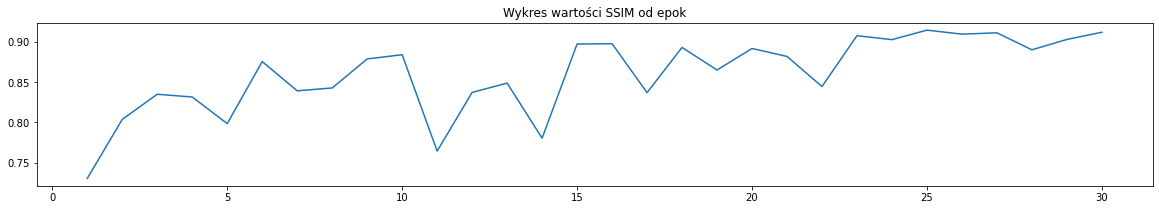

<Figure size 1440x216 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
df = pd.read_csv('xlsxs/srf_2_train_results.csv', sep=';').to_numpy()
ys = [float(i.replace(',','.')) for i in df[:,6]]
xs = list(df[:,0])
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(xs, ys)
plt.title('Wykres wartości SSIM od epok')
plt.show()
plt.figure().clear()
plt.clf()

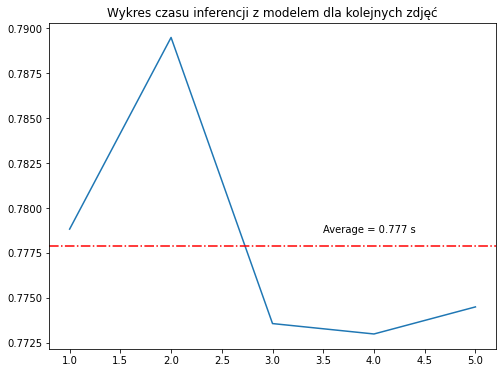

In [12]:
yst = [float(i.replace(',','.')) for i in df[:5,7]]
xst = list(df[:5,0])
plt.rcParams["figure.figsize"] = (8,6)
plt.plot(xst, yst)
avg = (sum(yst) / len(yst))
plt.annotate('{}'.format('Average = ' + str(avg)[:5] + ' s'), (3.5, avg*1.001))
plt.axhline(avg, color='r', linestyle='-.')
plt.title('Wykres czasu inferencji z modelem dla kolejnych zdjęć')
plt.show()

# Własny kod
<br></br>
Z uwagi na błąd znajdujący się w skrypcie z repozytorium przeznaczonym do testowania modelu, napisano własny skrypt:

(600, 600, 3)
time: 1.293 s


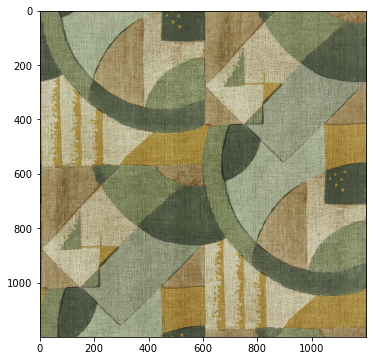

In [13]:
import cv2
import time
import numpy as np
from tqdm import tqdm
import torch.utils.data
from pathlib import Path
import torch.optim as optim
import torchvision.utils as utils
from torch.autograd import Variable
from torch.utils.data import DataLoader
from models.model import Generator, Discriminator
from torchvision.transforms import ToTensor, ToPILImage

UPSCALE_FACTOR = 2
MODEL_NAME = 'netG_epoch_2_30.pth'
IMAGE_NAME = Path('./pictures/ResizedSRGAN2/test.png')
OUTPUT_PATH = Path('')
SAVE = False

model = Generator(UPSCALE_FACTOR)    
if torch.cuda.is_available():
    model.cuda()    
model.load_state_dict(torch.load('models/' + MODEL_NAME))
model.eval()

with torch.no_grad():
    image = cv2.imread(str(IMAGE_NAME))
    print(image.shape)
    image = Variable(ToTensor()(image)).unsqueeze(0).cuda()
    start = time.perf_counter()
    out = model(image)
    elapsed = (time.perf_counter() - start)
    print('time: ' + str(elapsed)[:5] + ' s')
    out_img = ToPILImage()(out[0].data.cpu())
    out_img = cv2.cvtColor(np.array(out_img), cv2.COLOR_RGB2BGR)
    plt.imshow(out_img)
    plt.show()

# Porównanie SRGAN (2) do oryginalnych zdjęć 
<br></br>
Sieć jako wejście przyjmuje kwadratowe obazy. Do inferencji z modelem użyto obrazów o wymiarach 1200x1200 px pomnijeszonych dwukrotnie liniową funkcją z biblioteki *cv2*. 
<br></br>
Kolejność:
<ol>
    <li>Oryginał</li>
    <li>SRGAN (2)</li>
</ol>

<br></br>
![3](.\pictures\Originals2\1s.jpg)
![3](.\pictures\SRGAN2\1s.png)
<br></br>
![3](.\pictures\Originals2\2s.jpg)
![3](.\pictures\SRGAN2\2s.png)
<br></br>
![3](.\pictures\Originals2\3s.jpg)
![3](.\pictures\SRGAN2\3s.png)
<br></br>
![3](.\pictures\Originals2\4s.jpg)
![3](.\pictures\SRGAN2\4s.png)
<br></br>
![3](.\pictures\Originals2\5s.jpg)
![3](.\pictures\SRGAN2\5s.png)

# Porównanie do standardowych metod:
<br></br>
Powiększono obrazy za pomocą funkcji *resize* z biblioteki *cv2*. Użyto następujących metod interpolacji:
<ul>
    <li>Linear - interpolacja bilinearna,</li>
    <li>Nearest - metoda najbliższego sąsiada,</li>
    <li>Area - podobna do liniowej ale zpobiega efektowi moiré,</li>
    <li>Cubic - interpolacja wielomianowa o polu 4x4,</li>
    <li>Lanczos4 - interpolacja wielomianowa o polu 8x8</li>
</ul>

In [14]:
print_compare('./pictures/StandardResizeSRGAN2/Linear','./pictures/Originals2', extensions=['png', 'jpg'])

,Id,0,1,2,3,4
0,Image name,1s,2s,3s,4s,5s
1,MSE,626.98,43.11,147.91,102.86,152.04
2,SSIM,0.873,0.9598,0.894,0.8863,0.8142
3,SSIM %,87.3,95.98,89.4,88.63,81.42


,Mean,Value
0,MSE,214.58
1,SSIM %,88.54


In [15]:
print_compare('./pictures/StandardResizeSRGAN2/Area','./pictures/Originals2', extensions=['png', 'jpg'])

,Id,0,1,2,3,4
0,Image name,1s,2s,3s,4s,5s
1,MSE,852.02,67.39,190.01,130.98,168.64
2,SSIM,0.8822,0.945,0.893,0.8841,0.833
3,SSIM %,88.22,94.5,89.3,88.41,83.3


,Mean,Value
0,MSE,281.80
1,SSIM %,88.74


In [16]:
print_compare('./pictures/StandardResizeSRGAN2/Nearest','./pictures/Originals2', extensions=['png', 'jpg'])

,Id,0,1,2,3,4
0,Image name,1s,2s,3s,4s,5s
1,MSE,852.02,67.39,190.01,130.98,168.64
2,SSIM,0.8822,0.945,0.893,0.8841,0.833
3,SSIM %,88.22,94.5,89.3,88.41,83.3


,Mean,Value
0,MSE,281.80
1,SSIM %,88.74


In [17]:
print_compare('./pictures/StandardResizeSRGAN2/Cubic','./pictures/Originals2', extensions=['png', 'jpg'])

,Id,0,1,2,3,4
0,Image name,1s,2s,3s,4s,5s
1,MSE,354.8,20.69,83.6,71.51,119.58
2,SSIM,0.9158,0.9791,0.9207,0.9091,0.8492
3,SSIM %,91.58,97.91,92.07,90.91,84.92


,Mean,Value
0,MSE,130.03
1,SSIM %,91.47


In [18]:
print_compare('./pictures/StandardResizeSRGAN2/Lanczos4','./pictures/Originals2', extensions=['png', 'jpg'])

,Id,0,1,2,3,4
0,Image name,1s,2s,3s,4s,5s
1,MSE,337.71,18.02,74.41,67.98,118.28
2,SSIM,0.9059,0.9815,0.9245,0.9097,0.8497
3,SSIM %,90.59,98.15,92.45,90.97,84.97


,Mean,Value
0,MSE,123.28
1,SSIM %,91.42


# PODSUMOWANIE

<br></br>

Na podstawie przeprowadzonych eksperymentów stwierdzono, że sieci GAN (przynajmniej dla użytych implementacji) bardzo dobrze radzą sobie ze skalowaniem obrazów dla współczynnika równego 2. Jednak porównując wyniki sieci GAN do innych niż liniowa metoda interpolacji metod, okazuje się, że istnieją lepsze sposoby na zwiększanie rozmiaru zdjęć. Należy jednak wziąć pod uwagę, że wyniki zostały otrzymane na podstawie bardzo małej liczby obrazów, co niezaprzeczalnie wpływa na interpretacje wyników. Dla większości najlepszych użytych w porównaniu metod różnice między powiększonymi dzięki nim obrazami są w większości niewidoczne gołym okiem. Niewykluczone, że użycie modelu wytrenowanego na dużo większym zbiorze i dla optymalnej liczby epok (early stopping) byłoby w stanie osiągnąć lepsze wyniki niż którakolwiek z metod interpolacji. 

Metody zwiększania rozdzielczości obrazów za pomocą sieci GAN dla współczynników skali większych niż pierwsza potęga liczby dwa (skalowanie co kolejne potęgi 2) na ten moment osiągają gorsze wyniki od najgorszej z metod interpolacji. 

Faktem, na który należy zwrócić uwagę są duże wymogi sprzętowe potrzebne do wytrenowania sieci. Im większy współczynnik skali tym większy model i co za tym idzie złożoność obliczeniowa.

# Kod

<br></br>
https://github.com/BAPO-Developers/ImageUpscaler_GAN_project

# Sprzęt

<br></br>
Trening sieci SRGAN został wykonany na sprzęcie o następujących parametrach:

<ul>
<li> GPU - GTX 1660 SUPER 6GB VRAM</li>
<li> CPU - Ryzen 7 3700x</li>
<li> 16 GB RAM</li>
</ul>


# Referencje
<br></br>
<ul>
    <li>[1] https://github.com/brade31919/SRGAN-tensorflow</li>
    <li>[2] https://github.com/trevor-m/tensorflow-SRGAN</li>
    <li>[3] https://github.com/IBM/MAX-Image-Resolution-Enhancer</li>
    <li>[4] https://storage.googleapis.com/openimages/web/index.html</li>
    <li>[5] https://quay.io </li>
    <li>[6] https://www.docker.com</li>
    <li>[7] C. Ledig, L. Theis, F. Huszar, J. Caballero, A. Cunningham, A. Acosta, A. Aitken, A. Tejani, J. Totz, Z. Wang, W. Shi, Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network, ArXiv, 2017.</li>
    <li>[8] https://pytorch.org </li>
    <li>[9] https://github.com/Lornatang/SRGAN-PyTorch </li>
    <li>[10] https://github.com/Lornatang/RFB_ESRGAN-PyTorch </li>
    <li>[11] https://data.vision.ee.ethz.ch/cvl/DIV2K/ </li>    
    <li>[12] https://github.com/leftthomas/SRGAN </li>    
    
   
</ul>